In [1]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import e_charge, planck_h, phi0, get_Ic_from_Lj
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_ck_to_ground, get_ck
from modeling.resonance_fit import ResFit
from modeling.chips.detection_device_2s1a.utils import get_transmission_line_tee_points, NetworkAnalysis

In [2]:
cap_to_ground = digit_tee_ck_to_ground()

In [3]:
a = 10e-6
b = 6e-6
ep_r = 11.45
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real

rr_freq_target = np.array([7.4e9, 7.2e9, 7.6e9])
l_rr = Z0*pi/(4*pi*rr_freq_target)
c_rr = 1/((2*pi*rr_freq_target)**2*l_rr)

cplr_freq_target = np.array([7.0e9, 6.8e9])
l_cr = Z0*pi/(4*pi*cplr_freq_target)
c_cr = 1/((2*pi*cplr_freq_target)**2*l_cr)

c_sigma_a = 91e-15
c_sigma_s = 100e-15
kappa_target = 2e6
qubit_freq_target = [5e9, 4.5e9, 5.1e9]

Lj_s1, Lj_s2, Lj_a, c_c_s1_a_sensing_side, c_c_s1_a_ancilla_side, c_c_s2_a_sensing_side, c_c_s2_a_ancilla_side, c_r_s1, c_r_s2, c_r_a, g_s1, g_s2, g_a, ck_s1, ck_s2, ck_a = np.load("params_.npy")

# Readout structure for S1
Here we compute the S21 for the Sensing 1 qubit feedline.

In [4]:
transmission_line_tee_points_s1 = get_transmission_line_tee_points("detection_device_2s_1a_00.csv", 10, 6, "s1")

cfl = 3e-14

finger_control_cfl = get_ck(type = "smooth_capacitor")(cfl)
print(f"Finger control probeline capacitor: {finger_control_cfl:.5}")

finger_control_ck = get_ck(type = "digittee")(ck_s1)
print(f"Finger control readout resonator: {finger_control_ck:.5}")

Finger control probeline capacitor: 3.4432
Finger control readout resonator: 2.1464


In [ ]:
resonator_capacitance_s1 = c_rr[0] -ck_s1 -  c_r_s1
resonator_capacitance_s2 = c_rr[1] -ck_s2 -  c_r_s2
resonator_capacitance_a = c_rr[2] -ck_a -  c_r_a
options_s1 = {
    "qubit_c": [c_sigma_s],
    "qubit_l": [Lj_s1],
    "readout_resonator_c": [resonator_capacitance_s1],
    "readout_resonator_l": [l_rr[0]],
    "ck": [ck_s1],
    "ck_to_ground": [cap_to_ground(ck_s1)],
    "cqr": [c_r_s1],
    "feedline_traits": transmission_line_tee_points_s1,
    "cfl": cfl,
    "cfl_to_ground": cap_to_ground(cfl),
    "frequency": [6, 9],z
    "n_points": 1001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}
network_s1 = NetworkAnalysis(options=options_s1)

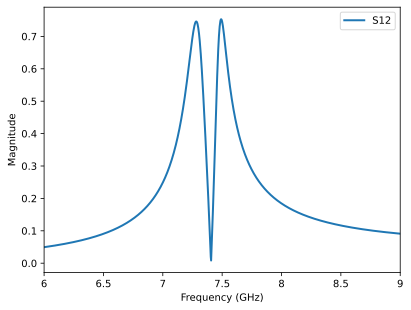

In [6]:
ntw = network_s1.s21_study()
ntw.plot_s_mag(m=0, n=1, lw=2)

In [17]:
t1_readout = network_s1.t1_purcell_readout(qb_frequency = 5, c_sigma = 100e-15)
t1_readout

0.0033457812296008647

In [8]:
options_s1_cplr = {
    "qubit_c": [c_sigma_s, c_sigma_a],
    "qubit_l": [Lj_s1, Lj_a],
    "readout_resonator_c": [resonator_capacitance_s1, resonator_capacitance_a],
    "readout_resonator_l": [l_rr[0], l_rr[2]],
    "ck": [ck_s1, ck_a],
    "ck_to_ground": [cap_to_ground(ck_s1)],
    "cqr": [c_r_s1, c_r_a],
    "feedline_traits": transmission_line_tee_points_s1[:3],
    "frequency": [4.99, 5.01],
    "n_points": 101,
    "type": "T1_Purcell_estimation_coupled_qubits",
    "decay_source": "readout_system",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6,
    "qubit_to_estimate": 0,
    "cc": np.array([c_c_s1_a_sensing_side, c_c_s1_a_ancilla_side]),
    "coupler_res_c": c_cr[0],
    "coupler_res_l": l_cr[0]
}
t1_coupler = network_s1.t1_purcell_coupler(qb_frequency = 5, options_cplr = options_s1_cplr)
t1_coupler

0.0038336630134710283

In [9]:
options_s1_cplr

{'qubit_c': [1e-13, 9.1e-14],
 'qubit_l': [9.3612954e-09, 9.817989150000001e-09],
 'readout_resonator_c': [2.553114424440113e-13, 2.490518898474567e-13],
 'readout_resonator_l': [1.719670385244819e-09, 1.674415901422587e-09],
 'ck': [8.705837671510099e-15, 8.364457064761524e-15],
 'ck_to_ground': [array(1.01567583e-14)],
 'cqr': [4.9699182500000004e-15, 4.4922409700000004e-15],
 'feedline_traits': [737.909, 395.738, 2882.8050000000003],
 'frequency': [4.99, 5.01],
 'n_points': 101,
 'type': 'T1_Purcell_estimation_coupled_qubits',
 'decay_source': 'readout_system',
 'a': 1e-05,
 'b': 6e-06,
 'ep_r': 11.45,
 'substrate_thickness': 0.00055,
 'qubit_to_estimate': 0,
 'cc': array([5.03033904e-15, 4.74285582e-15]),
 'coupler_res_c': 2.8435789541497983e-13,
 'coupler_res_l': 1.8179372644016659e-09}

In [10]:
# T1 Purcell - adapting the formula to the filter presence (eq. 178 of https://doi.org/10.1063/1.5089550):
g = g_s1 * 2*np.pi
purcell_Q = 15 # should be found from fitting.
delta = (rr_freq_target - 5e9)*2*np.pi
k_purcell_ = kappa_target* (g/delta)**2 
gamma_purcell = k_purcell_ * qubit_freq_target[0]*2*np.pi / (2*purcell_Q*delta)

T1_purcell = 1/gamma_purcell[0]
print(T1_purcell*1e6)

4693.147645684625


# Readout structure for S2

In [11]:
transmission_line_tee_points_s2 = get_transmission_line_tee_points("detection_device_2s_1a_00.csv", 10, 6, "s2")

fl_traits = pd.read_csv("detection_device_2s_1a_00.csv").values[1][1:]

fl_traits[3] = 
transmission_line_tee_points = [
    float(fl_traits[0]), # lp to input capacitor
    fl_traits[1] + (10 + 2*6)/2, # input capacitor to tee
    fl_traits[2] + fl_traits[3] + fl_traits[4] + (10 + 2*6), # tee to split point
    fl_traits[5] + (10 + 2*6)/2, # split point to lp
    30 + fl_traits[6] + fl_traits[7] # split point to ground

    ]

transmission_line_tee_points_s2[3]
cfl = 3e-14

finger_control_cfl = get_ck(type = "smooth_capacitor")(cfl)
print(f"Finger control probeline capacitor: {finger_control_cfl:.5}")

finger_control_ck = get_ck(type = "digittee")(ck_s1)
print(f"Finger control readout resonator: {finger_control_ck:.5}")

SyntaxError: invalid syntax (21828691.py, line 5)

In [ ]:
fl_traits[3]

1980.0

In [ ]:
resonator_capacitance = c_rr[1] - ck_s2 -  c_r_s2
options_s2 = {
    "qubit_c": [c_sigma_s],
    "qubit_l": [Lj_s2],
    "readout_resonator_c": [resonator_capacitance],
    "readout_resonator_l": [l_rr[1]],
    "ck": [ck_s2],
    "ck_to_ground": [cap_to_ground(ck_s2)],
    "cqr": [c_r_s2],
    "feedline_traits": transmission_line_tee_points_s2,
    "cfl": cfl,
    "cfl_to_ground": cap_to_ground(cfl),
    "frequency": [6, 9],
    "n_points": 1001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}
network_s2 = NetworkAnalysis(options=options_s2)

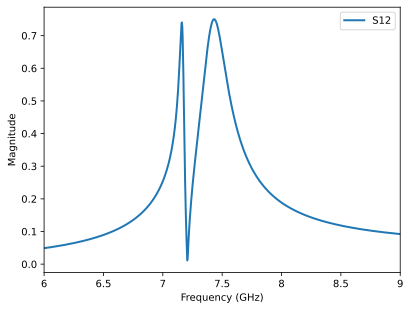

In [ ]:
ntw = network_s2.s21_study()
ntw.plot_s_mag(m=0, n=1, lw=2)

In [ ]:
t1_readout = network_s2.t1_purcell_readout(qb_frequency = 4.5, c_sigma = 100e-15)
t1_readout

0.008787297017814798

In [ ]:
options_s2_cplr = {
    "qubit_c": [c_sigma_s, c_sigma_a],
    "qubit_l": [Lj_s2, Lj_a],
    "readout_resonator_c": [resonator_capacitance_s2, resonator_capacitance_a],
    "readout_resonator_l": [l_rr[1], l_rr[2]],
    "ck": [ck_s2, ck_a],
    "ck_to_ground": [cap_to_ground(ck_s2)],
    "cqr": [c_r_s1, c_r_a],
    "feedline_traits": transmission_line_tee_points_s2[:3],
    "frequency": [4.49, 4.51],
    "n_points": 101,
    "type": "T1_Purcell_estimation_coupled_qubits",
    "decay_source": "readout_system",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6,
    "qubit_to_estimate": 0,
    "cc": np.array([c_c_s2_a_sensing_side, c_c_s2_a_ancilla_side]),
    "coupler_res_c": c_cr[1],
    "coupler_res_l": l_cr[1]
}
t1_coupler = network_s1.t1_purcell_coupler(qb_frequency = 4.5, options_cplr = options_s2_cplr)
t1_coupler

0.09576131018212616

# Readout structure for A

In [ ]:
transmission_line_tee_points_a = get_transmission_line_tee_points("detection_device_2s_1a_00.csv", 10, 6, "a")

cfl = 3e-14

finger_control_cfl = get_ck(type = "smooth_capacitor")(cfl)
print(f"Finger control probeline capacitor: {finger_control_cfl:.5}")

finger_control_ck = get_ck(type = "digittee")(ck_s1)
print(f"Finger control readout resonator: {finger_control_ck:.5}")

Finger control probeline capacitor: 3.4432
Finger control readout resonator: 2.1464


In [ ]:
resonator_capacitance = c_rr[2] - ck_a -  c_r_a
options_a = {
    "qubit_c": [c_sigma_a],
    "qubit_l": [Lj_a],
    "readout_resonator_c": [resonator_capacitance],
    "readout_resonator_l": [l_rr[2]],
    "ck": [ck_a],
    "ck_to_ground": [cap_to_ground(ck_a)],
    "cqr": [c_r_a],
    "feedline_traits": transmission_line_tee_points_a,
    "cfl": cfl,
    "cfl_to_ground": cap_to_ground(cfl),
    "frequency": [6, 9],
    "n_points": 1001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}
network_a = NetworkAnalysis(options=options_a)

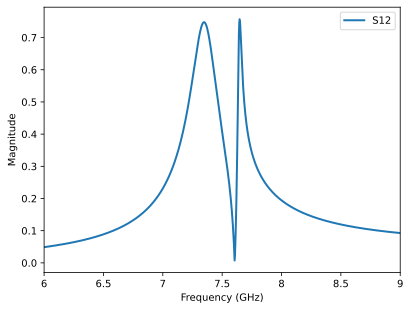

In [ ]:
ntw = network_a.s21_study()
ntw.plot_s_mag(m=0, n=1, lw=2)

In [ ]:
t1_readout = network_a.t1_purcell_readout(qb_frequency = 5.1, c_sigma = 90e-15)
t1_readout

0.003412723486975382

In [ ]:
options_a_cplr_to_s1 = options_s1_cplr.copy()
options_a_cplr_to_s1["frequency"] = [5.01, 5.11]
options_a_cplr_to_s1["qubit_to_estimate"] = 1
t1_coupler = network_s1.t1_purcell_coupler(qb_frequency = 5.1, options_cplr = options_a_cplr_to_s1)
t1_coupler

-0.006038725185815887

In [ ]:
options_a_cplr_to_s2 = options_s2_cplr.copy()
options_a_cplr_to_s1["frequency"] = [5.01, 5.11]
options_a_cplr_to_s1["qubit_to_estimate"] = 1
t1_coupler = network_s2.t1_purcell_coupler(qb_frequency = 5.1, options_cplr = options_a_cplr_to_s2)
t1_coupler

0.09142900138780516

# Purcell from fluxline
With good approximation fluxline Purcell limits are the same for all qubits.

In [ ]:
# Fluxline
# Cap matrix
# 1 island close to line
# 2 island far from line
# 3 line
# C11 = 162.48 - 40 - 0.62
# C22 = 159.19 - 40.04 - 0.4921
# C23 = 0.49218
# C13 = 0.62657

# C11 = 159.18 - 40.14 - 0.73450
# C22 = 159.20 - 40.14 - 0.55341
# C23 = 0.55341
# C13 = 0.74350


C11 = 158.86- 40.07 - 0.689
C22 = 158.86 - 40.06 - 0.53217
C23 = 0.53217
C13 = 0.68899

c_eff_flux = (C13*C22 - C23*C11) / (C11 + C13 + C22 + C23) * 1e-15
c_eff_flux
gamma_flux = (2*np.pi*np.array(qubit_freq_target))**2*c_eff_flux**2*50/c_sigma_s
T1_flux = 1/gamma_flux
print(T1_flux*1e6)

# 234.9 flux quanta/A

# phi0 =  2.067833848e-15 # Wb
flux_quantum = planck_h / 2 / e_charge
mutual_inductance = 234.9 * phi0
gamma_flux_inductive = (2*np.pi*np.array(qubit_freq_target))**2*mutual_inductance**2 / np.array([Lj_s1, Lj_s2, Lj_a]) / 50
T1_flux_inductive= 1/gamma_flux_inductive
print(T1_flux_inductive*1e6)

[329.38394322 406.64684348 316.59356326]
[2010.05941729 3037.87423615 2026.25990026]


# Purcell from driveline

In [ ]:
# Driveline S1
# Cap matrix
# 1 island close to line
# 2 island far from line
# 3 line
# C11 = 162.377 - 39.91 - 0.02495
# C22 = 162.53 - 39.91 - 0.05127
# C23 = 0.05127
# C13 = 0.02495

# C11 = 162.47 - 39.945 - 0.05109
# C22 = 162.56 - 39.925 - 0.09084
# C23 = 0.09084
# C13 = 0.05109

C11 = 162.42 - 39.86 - 0.06000
C22 = 162.52 - 39.86 - 0.11924
C23 = 0.11924
C13 = 0.06000

c_eff_drive = abs((C13*C22 - C23*C11) / (C11 + C13 + C22 + C23)) * 1e-15
print(c_eff_drive)
gamma_drive = (2*np.pi*np.array(qubit_freq_target[0]))**2*c_eff_drive**2*50/c_sigma_s
T1_drive= 1/gamma_drive
print(T1_drive*1e6)
Q_drive = 2*np.pi*np.array(qubit_freq_target[0]) / gamma_drive
print(Q_drive)

2.95834532256749e-17
2315.4345860634903
72741522.85444784


In [ ]:
# Driveline S2
# Cap matrix

C11 = 162.134 - 39.91 - 0.0428
C22 = 163.56 - 39.92 - 0.10183
C23 = 0.10183
C13 = 0.0428

c_eff_drive = abs((C13*C22 - C23*C11) / (C11 + C13 + C22 + C23)) * 1e-15
print(c_eff_drive)
gamma_drive = (2*np.pi*np.array(qubit_freq_target[1]))**2*c_eff_drive**2*50/c_sigma_s
T1_drive= 1/gamma_drive
print(T1_drive*1e6)
Q_drive = 2*np.pi*np.array(qubit_freq_target[1]) / gamma_drive
print(Q_drive)

2.9098517554420336e-17
2954.632721732514
83540272.07385792


In [ ]:
# Driveline A
# Cap matrix

C11 = 150.634 - 37.55 - 0.03686
C22 = 146.600 - 37.58 - 0.09978
C23 = 0.09978
C13 = 0.03686

c_eff_drive = abs((C13*C22 - C23*C11) / (C11 + C13 + C22 + C23)) * 1e-15
print(c_eff_drive)
gamma_drive = (2*np.pi*np.array(qubit_freq_target[2]))**2*c_eff_drive**2*50/c_sigma_a
T1_drive= 1/gamma_drive
print(T1_drive*1e6)
Q_drive = 2*np.pi*np.array(qubit_freq_target[2]) / gamma_drive
print(Q_drive)

3.271010121384576e-17
1656.561345253707
53083257.71519269
